In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kipet import KipetModel

### Simulating a fed batch reaction
$A + B \rightarrow C$

Initial conditions in reactor: 
* Initial volume $V_0=1L$
* $c_{A0} = 2, c_{B0} = 0, c_{C0} = 0$ (mol/L).

A stream of $B$ with concentration $2 mol/L$ is charged into reactor at rate $0.1 L/min$ over 15min.

Reaction rate constant $k_1=0.1 min^{-1}$

Governing equations are:
$$
\begin{eqnarray}
\frac{dc_A}{dt} &=& -\frac{c_Aqin_B}{V} - k_1c_Ac_B \\
\frac{dc_B}{dt} &=& \frac{(cin_B - c_B)qin_B}{V} - k_1c_Ac_B \\
\frac{dc_C}{dt} &=& -\frac{c_Cqin_B}{V} + k_1c_Ac_B \\
\frac{dV}{dt} &=& qin_B
\end{eqnarray}
$$

In [25]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('fed_batch_sim')

r1.add_parameter('k1', init = 0.1)

r1.add_component('A', state = 'concentration', init = 2.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_component('V', state = 'state', init = 1.0)

r1.add_component('qin_B', state = 'trajectory')
r1.add_algebraic_variables(['qin_B'])

In [26]:
cin_B = 2

def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.Z[t,'A'] * m.Y[t,'qin_B']/m.X[t,'V']-m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = (cin_B*m.Y[t,'qin_B'] - m.Z[t,'B'] * m.Y[t,'qin_B'])/m.X[t,'V']- m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['C'] = -m.Z[t,'C'] * m.Y[t,'qin_B']/m.X[t,'V'] + m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

r1.add_equations(rule_odes)

In [27]:
qin_B_df = pd.DataFrame({'t':[0, 15, 16], 'qin_B': [0.1, 0.1, 0]}).set_index('t')
qin_B_df

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [28]:
r1.add_dataset('Traj', category = 'trajectory', data = qin_B_df)

In [29]:
r1.datasets['Traj'].data

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [30]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')

In [31]:
r1.set_times(0, 60)
r1.simulate()

times are: <class 'tuple'>


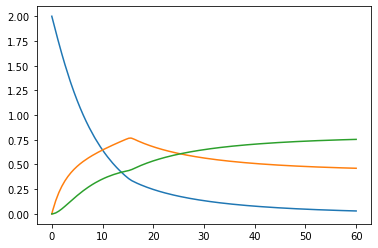

In [32]:
fig, ax = plt.subplots()
for c in ['A','B','C']:
    ax.plot(r1.results.Z.index, r1.results.Z[c])

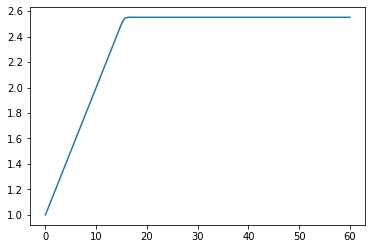

In [33]:
fig, ax = plt.subplots()
ax.plot(r1.results.X.index, r1.results.X['V'])

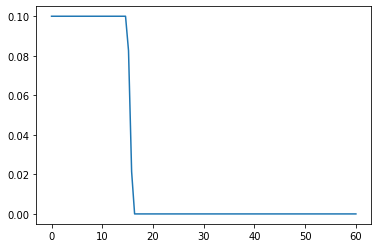

In [34]:
fig, ax = plt.subplots()
ax.plot(r1.results.Y.index, r1.results.Y['qin_B'])